In [1]:
# Vision Transformer (ViT) - classify the images (MNIST) with shape (N x 1 x 28 x 28)
import numpy as np
from tqdm import tqdm, trange # trange(i) is a special optimised instance of tqdm(range(i))

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [2]:
# Loading data
transform = ToTensor()

train_set = MNIST(root='./datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

Image size: torch.Size([1, 28, 28])


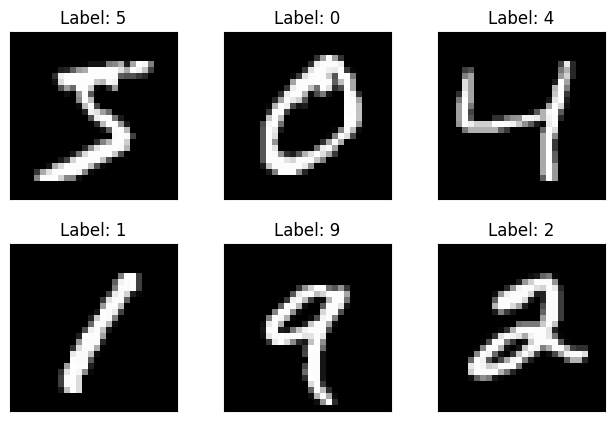

In [3]:
# Data sample
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_set[i][0].squeeze(dim=0), cmap='gray', interpolation='none')
    plt.title("Label: {}".format(train_set[i][1]))
    plt.xticks([])
    plt.yticks([])
fig

print("Image size: {}".format(train_set[0][0].shape)) # (C, H, W) = (1, 28, 28)

In [4]:
# Image patchify
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                # patch.shape -> (c, h // n_patches, w // n_patches)
                # patch.flatten().shape -> h * w * c // n_patches**2
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches 
    # patches.shape -> (n, n_patches**2, h * w * c // n_patches**2)

In [5]:
# Positional embeddings
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

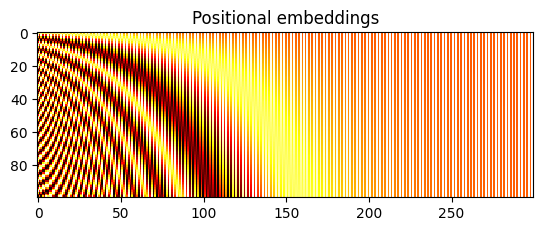

In [6]:
# Positional embeddings visualization
import matplotlib.pyplot as plt
plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.title("Positional embeddings")
plt.show()

In [7]:
# Multi-head self attention
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"
        d_head = int(d / n_heads)

        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head] # (d_head, d_head)
                k_mapping = self.k_mappings[head] # (d_head, d_head)
                v_mapping = self.v_mappings[head] # (d_head, d_head)

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head] # (seq_length, d_head)
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq) # (seq_length, d_head)

                attention = self.softmax(q @ k.T / (self.d_head**0.5)) # (seq_length, seq_length)
                seq_result.append(attention @ v) # (seq_length, d_head)
            result.append(torch.hstack(seq_result)) # (seq_length, token_dim)
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
        # torch.unsqueeze(r, dim=0) -> (1, seq_length, token_dim)
        # torch.cat -> (N, seq_length, token_dim)

In [8]:
# The encoder block of ViT
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        """ 
            Layer normalization: 
                Given an input, subtracts its mean and divides by the standard deviation.
                after normalization => mean=0, std=1, and get the same dimensionality.
        """
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [9]:
# ViT model
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        # Input and patches sizes
        assert (chw[1] % n_patches == 0), "Input shape not entirely divisible by number of patches"
        assert (chw[2] % n_patches == 0), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        """ 
            register_buffer:
                Tensor which is not a parameter, but should be part of the module state.
                Used for tensors that need to be on the same device as the module.
                This is typically used to register a buffer that should not to be considered a model parameter. 
                register_buffer(name, tensor, persistent=True):
                if persistent=True, tensor will be a part of this module's state_dict.
        """
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device) 
        # (n, n_patches**2, h * w * c // n_patches**2) = (n, 49, 16)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches) # (n, n_patches**2, hidden_d) = (n, 49, 8)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1) 
        # (n, n_patches**2 + 1, hidden_d) = (n, 50, 8)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        # (n, n_patches**2 + 1, hidden_d) = (n, 50, 8)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out) # (n, n_patches**2 + 1, hidden_d) = (n, 50, 8)

        # Getting the classification token (the first one) only
        out = out[:, 0] # (n, 8)

        # Map to output dimension, output category distribution
        return self.mlp(out) # (n, 10)

In [10]:
def main():
    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

    N_EPOCHS = 15
    LR = 0.002

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()

    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader) # train loss of each epoch
            """ 
                tensor.detach() creates a tensor that shares storage with tensor that does not require grad. 
                It detaches the output from the computational graph. 
                So no gradient will be backpropagated along this variable.

                The wrapper with torch.no_grad() temporarily set all the requires_grad flag to false. 
                torch.no_grad says that no operation should build the graph.

                The difference is that one refers to only a given variable on which it is called. 
                The other affects all operations taking place within the with statement. 
                Also, torch.no_grad will use less memory because it knows from the beginning 
                ... that no gradients are needed so it doesn't need to keep intermediary results.
            """

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
            
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

In [11]:
if __name__ == "__main__":
    main()

Using device:  cpu 


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   7%|▋         | 1/15 [03:08<44:04, 188.93s/it]

Epoch 1/15 loss: 2.17


Training:  13%|█▎        | 2/15 [06:40<43:47, 202.12s/it]

Epoch 2/15 loss: 1.99


Training:  20%|██        | 3/15 [09:58<40:04, 200.34s/it]

Epoch 3/15 loss: 1.90


Training:  27%|██▋       | 4/15 [13:13<36:19, 198.16s/it]

Epoch 4/15 loss: 1.83


Training:  33%|███▎      | 5/15 [16:31<33:00, 198.05s/it]

Epoch 5/15 loss: 1.79


Training:  40%|████      | 6/15 [19:53<29:54, 199.43s/it]

Epoch 6/15 loss: 1.75


Training:  47%|████▋     | 7/15 [24:05<28:53, 216.68s/it]

Epoch 7/15 loss: 1.72


Training:  53%|█████▎    | 8/15 [27:36<25:04, 214.88s/it]

Epoch 8/15 loss: 1.69


Training:  60%|██████    | 9/15 [31:08<21:23, 213.89s/it]

Epoch 9/15 loss: 1.67


Training:  67%|██████▋   | 10/15 [34:36<17:41, 212.26s/it]

Epoch 10/15 loss: 1.66


Training:  73%|███████▎  | 11/15 [38:06<14:05, 211.36s/it]

Epoch 11/15 loss: 1.65


Training:  80%|████████  | 12/15 [41:39<10:35, 211.93s/it]

Epoch 12/15 loss: 1.64


Training:  87%|████████▋ | 13/15 [45:08<07:02, 211.02s/it]

Epoch 13/15 loss: 1.63


Training:  93%|█████████▎| 14/15 [48:39<03:31, 211.11s/it]

Epoch 14/15 loss: 1.62


Training: 100%|██████████| 15/15 [52:10<00:00, 208.73s/it]


Epoch 15/15 loss: 1.62


Testing: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]

Test loss: 1.61
Test accuracy: 85.29%
